In [1]:
blocks_teleports__patterns = [
    {
        'blocks': {
            (2, 0): [(-1, -1), (0, -1), (1, -1)],
            (2, 4): [(0, 1)]            
        }, 
         'teleports': []
    },
    {
        'blocks': {
            (2, 0): [(-1, -1), (0, -1), (1, -1)],
            (2, 4): [(0, 1)]            
        }, 
         'teleports': [
             {'from': [(2, 4), (-1, 0)],
              'to': [(1, 3)],
              'arrow_sides': [(-1, 1), (0, 1)]},
             {'from': [(2, 4), (1, 0)],
              'to': [(3, 3)],
              'arrow_sides': [(1, 1), (0, 1)]}
         ]
    },
    {
        'blocks': {
            (1, 0): [(0, -1)],
            (3, 0): [(0, -1)],
            (1, 3): [(0, 1)],
            (3, 3): [(0, 1)],
        }, 
         'teleports': []
    },
    {
        'blocks': {
            (1, 0): [(0, -1)],
            (2, 0): [(0, -1)],
            (3, 0): [(0, -1)],
            (1, 3): [(0, 1)],
            (3, 3): [(0, 1)],
        }, 
         'teleports': []
    },
]

btp_idx = 3

def get_filename(index):
    return 'hexflower layout_{}.json'.format(index+1)

filename = get_filename(btp_idx)

btp = []

def set_btp(idx):
    global btp
    btp = blocks_teleports__patterns[idx]
set_btp(btp_idx)

test_run = False
generate_data = False
generate_images = False
generate_compare_layout_images = False
generate_compare_n_iter_images = False
generate_draw_compare_groups = True

In [2]:
import random
import numpy as np
import json

n_cols = 5
n_rows = [3, 4, 5, 4, 3]

def roll():
    return random.randint(1, 6) + random.randint(1, 6)

def get_move_coord(roll_val, curr_hex):
    if roll_val == 12:
        return 0, -1
    if roll_val >= 6 and roll_val <= 7:
        return 0, 1

    x = 0
    y = 0
    
    if roll_val <= 5:
        x = 1
        if roll_val <= 3:
            y = 0
        else:
            y = 1
        if curr_hex[0] >= 2:
            y -= 1
    elif roll_val >= 8 and roll_val <= 11:
        x = -1
        if roll_val <= 9:
            y = 1
        else:
            y = 0
        if curr_hex[0] <= 2:
            y -= 1
    return x, y    

def is_blocked(hex_coord, move_coord):
    return hex_coord in btp['blocks'] and move_coord in btp['blocks'][hex_coord]

def get_next_hex(curr_hex, r=None):
    if r is None:
        r = roll()
    # print(r)
    move_coord = get_move_coord(r, curr_hex)
    if is_blocked(curr_hex, move_coord):
        return curr_hex

    # print(btp['teleports'], 'curr:', curr_hex, 'move:', move_coord)
    for teleport_definition in btp['teleports']:
        t_from = teleport_definition['from']
        if t_from[0] == curr_hex and t_from[1] == move_coord:
            result = teleport_definition['to'][0]
            # print('teleporting!', teleport_definition, result)
            return result
    
    curr_x = curr_hex[0]
    curr_y = curr_hex[1]
    new_x = curr_hex[0] + move_coord[0]
    new_y = curr_hex[1] + move_coord[1]
    
    if new_x == -1:
        if move_coord[1] == -1:
            new_x = 4 - curr_y
            new_y = n_rows[new_x] - 1
        else:
            new_x = 2 + curr_y
            new_y = 0
    elif new_x == 5:
        if move_coord[1] == -1:
            new_x = curr_y
            new_y = n_rows[new_x] - 1
        else:
            new_x = 2 - curr_y
            new_y = 0
    elif new_y == -1:
        if move_coord[0] == 0:
            new_y = n_rows[new_x] - 1
        elif move_coord[0] == 1:
            new_x = 0
            new_y = curr_x - 2
        else:
            new_x = 4
            new_y = 2 - curr_x
    elif new_y == n_rows[new_x]:
        if move_coord[0] == 0:
            new_y = 0
        elif move_coord[0] == 1:
            new_x = 0
            new_y = 4 - curr_x
        else:
            new_x = 4
            new_y = curr_x

    return new_x, new_y

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

collections = {
    'top': ((2, 0), ),
    'collar': ((1, 0), (2, 1), (3, 0)),
    'left_lobe': ((0, 0), (0, 1), (1, 1)),
    'right_lobe': ((3, 1), (4, 0), (4, 1)),
    'center': ((2, 2), ),
    'belt': ((0, 2), (1, 2), (1, 3), (2, 3), (3, 2), (3, 3), (4, 2)),
    'bottom': ((2, 4), )
}

n_iters = [3, 5, 10, 15, 20, 25, 33, 50, 100, 1000, 10000, 100000]


In [3]:
if generate_data:
    
    out = []
    
    for start_hex in [(2, 2), (2, 4)]:
        for n_iter in n_iters:
            n_sim_total = int(10000000 / n_iter)
            # n_sim_total = int(1000000 / n_iter)
            print('start: {}, n_iter: {}, n_sim_total: {}'.format(start_hex, n_iter, n_sim_total))
            if n_sim_total < 1:
                continue
            
            
            obj = {}
            obj['start_hex'] = str(start_hex) 
            obj['n_iter'] = n_iter
            obj['hexes'] = {}
            
            encounter_mtx_all = np.zeros((5, 5, n_sim_total))
            
            for n_sim in range(n_sim_total):
                encounter_mtx = np.zeros((5, 5))
                hex = start_hex
                for _ in range(n_iter):
                    encounter_mtx[hex[0], hex[1]] += 1
                    hex = get_next_hex(hex)
                # print(encountered_count)
    
                encounter_mtx_all[:,:,n_sim] = encounter_mtx
    
            # print('starting hex:\t', start_hex)
            # print('max moves:\t', n_iter)
    
            mean = np.mean(encounter_mtx_all, axis=2)
            # print('mean\n', mean)
    
            std = np.std(encounter_mtx_all, axis=2)
            # print('std\n', std)
    
            median = np.median(encounter_mtx_all, axis=2)
            # print('median\n', median)
    
            non_zero = np.count_nonzero(encounter_mtx_all, axis=2).astype(float)
            non_zero /= n_sim_total
            non_zero *= 100
            # print('non_zero\n', non_zero)
    
            p_of_all = np.sum(encounter_mtx_all, axis=2)
            p_of_all /= n_sim_total * n_iter
            p_of_all *= 100
            # print(p_of_all)
    
            for x in range(5):
                for y in range(n_rows[x]):
                    obj['hexes'][str((x, y))] = {
                        'mean': "{:.2f}".format(mean[x][y]),
                        'std': "{:.2f}".format(std[x][y]),
                        'median': "{:d}".format(int(median[x][y])),
                        'non_zero': "{:.1f}%".format(non_zero[x][y]),
                        'p_of_all_visits': "{:.1f}%".format(p_of_all[x][y]),
                    }
    
            obj['collections'] = {}
    
            for name, coords_list in collections.items():
                arr = np.zeros((n_sim_total))
                for coords in coords_list:
                    arr += encounter_mtx_all[coords[0]][coords[1]]
                obj['collections'][name] = {
                    'mean': "{:.2f}".format(np.mean(arr)),
                    'std': "{:.2f}".format(np.std(arr)),
                    'median': "{:d}".format(int(np.median(arr))),
                    'non_zero': "{:.1f}%".format(np.count_nonzero(arr) / n_sim_total * 100),
                    'p_of_all_visits': "{:.1f}%".format(np.sum(arr) / n_sim_total / n_iter * 100)
                }
    
            out.append(obj)
    
            print(obj)
            print()
    
    print(json.dumps(out))
    with open(filename, 'w') as fp:
        json.dump(out, fp, sort_keys=True, indent=2)

else:
    print('data generation skipped')

data generation skipped


In [4]:
from PIL import Image, ImageDraw, ImageFont, ImageColor
import math
import json

data = []

def load_data(btp_index):
    filename = get_filename(btp_index)
    loaded_data = []
    global data
    with open(filename, 'r') as fp:
        loaded_data = json.load(fp)
    data = loaded_data
    return loaded_data

load_data(btp_idx)

circle_radius = 75
h = circle_radius * 1.7320508 / 2
fontsize = 16

padding = 25
y_padding = fontsize * 5
flower_offset = circle_radius * 8 + padding * 2 + padding

def calc_image_size(n_columns, n_rows):
    width = int(circle_radius * 8 + padding * 2 + padding) * n_columns
    height = int(h * 10 + padding * 2 + y_padding) * n_rows + padding
    return width, height

image_width, image_height = calc_image_size(2, 2)

# get a font
fnt = ImageFont.truetype(r'c:\windows\fonts\arial.ttf', fontsize)

n_cols = 5
n_rows = [3, 4, 5, 4, 3]

base_colors = (
    (255, 89, 94),
    (255, 202, 58),
    (138, 201, 38),
    (25, 130, 196)
)

def get_cell_pos(x_idx, y_idx):
    x = circle_radius * (1 + x_idx * 3 / 2)
    x += padding
    y = h * (1 + y_idx * 2)
    y += abs(2 - x_idx) * h
    y += padding
    y += y_padding
    return x, y

def draw_cell(image, image_draw, x, y, text, text_offset, fill_color, outline_color, outline_width):
    temp_image = Image.new('RGBA', image.size, (0, 0, 0, 0))
    temp_draw = ImageDraw.Draw(temp_image, "RGBA")
    temp_draw.regular_polygon((x, y, circle_radius), 6, 0, fill_color, outline_color, outline_width)
    image.paste(Image.alpha_composite(image, temp_image))
    
    if text:
        image_draw.multiline_text(
            (x + text_offset[0], y + text_offset[1]), 
            text, 
            font=fnt, 
            fill=(0, 0, 0)
        )

def calc_btp_basepoint(x, y, direction):
    if direction[0] == 0:
        y += circle_radius * 1.0 * direction[1]
    else:
        x += circle_radius * 0.85 * direction[0]
        y += h * 0.6 * direction[1]
    return x, y

def draw_btp_blocks(image_draw, offset, blocks):
    
    for hex_id, directions_list in blocks.items():
        for direction in directions_list:
            position = list(get_cell_pos(*hex_id))
            position = calc_btp_basepoint(*position, direction)
            
            draw_cross(image_draw, position[0] + offset[0], position[1] + offset[1])

def draw_cross(image_draw, x, y):
    size = 5
    image_draw.line(((x-size, y-size), (x+size, y+size)), (0, 0, 0), 1)
    image_draw.line(((x+size, y-size), (x-size, y+size)), (0, 0, 0), 1)

def draw_btp_teleports(image_draw, offset, teleports):
    for tp in teleports:
        pt_a = get_cell_pos(*tp['from'][0])
        pt_a = list(calc_btp_basepoint(*pt_a, tp['arrow_sides'][0]))
        pt_a[0] += offset[0]
        pt_a[1] += offset[1]

        pt_b = get_cell_pos(*tp['to'][0])
        pt_b = list(calc_btp_basepoint(*pt_b, tp['arrow_sides'][1]))
        pt_b[0] += offset[0]
        pt_b[1] += offset[1]

        draw_arrow(image_draw, tuple(pt_a), tuple(pt_b))

def rotate_point(pt, origin, angle):
    s = math.sin(angle)
    c = math.cos(angle)
    px = pt[0]
    py = pt[1]
    ox = origin[0]
    oy = origin[1]
    px -= ox
    py -= oy
    px, py = px * c - py * s, px * s + py * c
    result = px + ox, py + oy
    return result

def draw_arrow(image_draw, pt_a, pt_b):
    image_draw.line((pt_a, pt_b), (0, 0, 0), 1)
    line_dx = pt_a[0] - pt_b[0]
    line_dy = pt_a[1] - pt_b[1]
    vec_len = math.sqrt(line_dx * line_dx + line_dy * line_dy)
    line_dx /= vec_len
    line_dy /= vec_len
    length = circle_radius * 0.15
    line_dx *= length
    line_dy *= length
    ang = 0.5
    for angle in (-ang, ang):
        pt = (pt_b[0] + line_dx, pt_b[1] + line_dy)
        pt = rotate_point(pt, pt_b, angle)
        image_draw.line((pt, pt_b), (0, 0, 0), 1)    
    

# counting clockwise from top-right
def get_hex_vertices(x_idx, y_idx):
    x, y = get_cell_pos(x_idx, y_idx)
    return (
        (x + circle_radius * 0.5, y - h),
        (x + circle_radius, y),
        (x + circle_radius * 0.5, y + h),
        (x - circle_radius * 0.5, y + h),
        (x - circle_radius, y),
        (x - circle_radius * 0.5, y - h)
    )

# edge indices clockwise from top
def get_hex_edges(x_idx, y_idx, edge_indices):
    vertices = get_hex_vertices(x_idx, y_idx)
    result = []
    for edge_idx in edge_indices:
        start_vertex_idx = (edge_idx - 1 + 6) % 6
        end_vertex_idx = edge_idx
        result.append((
            vertices[start_vertex_idx][0], vertices[start_vertex_idx][1],
            vertices[end_vertex_idx][0], vertices[end_vertex_idx][1]
        ))
    return result   

def add_tuples(a, b):
    return [(x[0] + y[0], x[1] + y[1]) for x, y in zip(a, b)]

    

In [5]:
def draw_flower(
    image,
    image_draw,
    coordinates,
    labels,
    base_color,
    alphas,
    offset,
    flower_label,
    # cross_positions,
    edges,
    hex_outline_width = 1
):
    for idx in range(len(coordinates)):
        coords = coordinates[idx]
        x, y = get_cell_pos(*coords)

        if labels:
            label = labels[idx]
            text_offset = (
                image_draw.textlength(label.split('\n')[0], font=fnt) * -0.5, 
                -fontsize * 0.5 * (1 + label.count('\n'))
            )
        else:
            label = None
            text_offset = None
        
        draw_cell(
            image,
            image_draw,
            x + offset[0],
            y + offset[1],
            label,
            text_offset,
            (base_color[0], base_color[1], base_color[2], alphas[idx]),
            # (0, 0, 0) if is_starting else base_colors[i],
            base_color,
            # 3 if is_starting else 1
            hex_outline_width
        )

        
    sublabel_texts_offset = image_draw.textlength(flower_label, font=fnt) * -0.5

    image_draw.text(
        (
            # padding + sublabel_texts_offset + flower_offset * (0.5) - padding * 2 + offset[0], 
            padding + sublabel_texts_offset + flower_offset * (0.5) - padding * 1.5 + offset[0], 
            padding + fontsize * 2 + offset[1]
        ), 
        flower_label, 
        font=fnt,
        fill=(0, 0, 0)
    )    

    draw_btp_blocks(image_draw, offset, btp['blocks'])
    draw_btp_teleports(image_draw, offset, btp['teleports'])

    # edges:
    # [edge_collection_1, edge_collection_2...]
    # edge_collection:
    # {'color' = (x, x, x), 'width' = x, 'edges' = ((p0x, p0y, p1x, p1y), (...)...)}
    for edge_collection in edges:
        width = edge_collection['width']
        color = edge_collection['color']
        for e in edge_collection['edges']:
            image_draw.line(((e[0] + offset[0], e[1] + offset[1]), (e[2] + offset[0], e[3] + offset[1])), color, width)

In [6]:
def draw_image(flower):

    # create an image
    image = Image.new("RGBA", (image_width, image_height), (255, 255, 255))
    # out.putalpha(1)
   
    # get a drawing context
    d = ImageDraw.Draw(image)
    d.rectangle(((0, 0), image.size), fill=(255, 255, 255))
    
    coordinates = []
    non_zeros = []
    p_of_all_visits = []
    medians = []
    means = []
    stds = []
    
    for key, value in flower['hexes'].items():
        coord = eval(key)
        coordinates.append(coord)
        non_zeros.append(float(value['non_zero'].rstrip('%')))
        p_of_all_visits.append(float(value['p_of_all_visits'].rstrip('%')))
        medians.append(int(value['median']))
        means.append(float(value['mean']))
        stds.append(float(value['std']))
    
    image_flower_offsets = (
        (0, 0),
        (flower_offset, 0),
        (0, flower_offset + y_padding),
        (flower_offset, flower_offset + y_padding)
    )

    labels = [
        ['{}%'.format(x) for x in non_zeros],
        ['{}%'.format(x) for x in p_of_all_visits],
        [str(x) for x in medians],
        ['x: {}\nσ: {}'.format(x, y) for x, y in zip(means, stds)]
    ]

    alphas = [
        [int(x * 2.55) for x in non_zeros],
        [int(x / max(p_of_all_visits) * 255) for x in p_of_all_visits],
        [int(x / max(medians) * 255) for x in medians],
        [int(x / max(means) * 255) for x in means]
    ]

    image_flower_labels = [
        "probability of visiting a hex at least once",
        "percentage of all visits",
        "number of visits: median",
        "number of visits: mean and standard deviation"
    ]

    start_hex = eval(flower['start_hex'])
    edges = [{'width': 3, 'color': (0, 0, 0), 'edges': get_hex_edges(*start_hex, range(6))}]

    for i in range(4):
        draw_flower(
            image,
            d,
            coordinates,
            labels[i],
            base_colors[i],
            alphas[i],
            image_flower_offsets[i],
            image_flower_labels[i],
            # cross_positions,
            edges
        )
            
    # draw multiline text
    label = "layout {}, {} steps, starting hex: {}".format(btp_idx+1, flower['n_iter'], flower['start_hex'])
    d.text((padding, padding), label, font=fnt, fill=(0, 0, 0))
    
    return image

image = ''

if generate_images:
    for flower in data:
        # print(flower)    
        image = draw_image(flower)
        fn = "layout_{}_start_{}_{}_n_steps_{}.png".format(btp_idx+1, eval(flower['start_hex'])[0], eval(flower['start_hex'])[1], flower['n_iter'])
        image.save(fn)
        if test_run:
            break
    
image

''

In [7]:
def get_collections_edges(color, start_hex):
    # edges = [{'width': 3, 'color': (0, 0, 0), 'edges': get_hex_edges(*start_hex, range(6))}]
    edges_base = []
    hex_edges = {
        (0, 0): [0, 4, 5],
        (0, 1): [2, 3, 4, 5],
        (0, 2): [3, 4, 5],
        (1, 0): [0, 1, 3, 4, 5],
        (1, 1): [1, 2, 3],
        (1, 2): [1],
        (1, 3): [2, 3, 4],
        (2, 0): [0, 1, 2, 3, 5],
        (2, 1): [2, 3],
        (2, 2): [1, 2, 3],
        (2, 3): [3],
        (2, 4): [1, 2, 3, 4],
        (3, 0): [0, 1, 2, 3],
        (3, 1): [3],
        (3, 2): [1],
        (3, 3): [2, 3],
        (4, 0): [0, 1, 2],
        (4, 1): [1, 2, 3, 4],
        (4, 2): [1, 2, 3]
     }

    for key, value in hex_edges.items():
        edges_base += get_hex_edges(*key, value)
    edges = [
        {'width': 1, 'color': color, 'edges': edges_base}, 
        {'width': 3, 'color': (0, 0, 0), 'edges': get_hex_edges(*start_hex, range(6))}
    ]
    
    return edges

def draw_collections_flower(
    image, 
    image_draw,
    flower, 
    offset,
    image_type_idx=0,
    label_override=None
):
    
    collection_labels = []
    coordinates = []
    non_zeros = []
    p_of_all_visits = []
    medians = []
    means = []
    stds = []
    
    for key, value in flower['collections'].items():
        coordinates += collections[key]
        collection_labels.append(key)
        for _ in collections[key]:
            non_zeros.append(float(value['non_zero'].rstrip('%')))
            p_of_all_visits.append(float(value['p_of_all_visits'].rstrip('%')))
            medians.append(int(value['median']))
            means.append(float(value['mean']))
            stds.append(float(value['std']))

    alphas = [
        [int(x * 2.55) for x in non_zeros],
        [int(x / max(p_of_all_visits) * 255) for x in p_of_all_visits],
        [int(x / max(medians) * 255) for x in medians],
        [int(x / max(means) * 255) for x in means]
    ]

    image_flower_labels = [
        "probability of visiting a group at least once",
        "percentage of all visits",
        "number of visits: median",
        "number of visits: mean and standard deviation"
    ]

    start_hex = eval(flower['start_hex'])
    edges = [get_collections_edges(x, start_hex) for x in base_colors]

    draw_flower(
        image,
        image_draw,
        coordinates,
        None,
        base_colors[image_type_idx],
        alphas[image_type_idx],
        offset,
        label_override if label_override else image_flower_labels[image_type_idx],
        # cross_positions,
        edges[image_type_idx],
        hex_outline_width=0
    )

    for label, data in flower['collections'].items():
        # print(label, data)
        hex_coords = collections[label]
        if label == 'collar':
            hex_coords = ((2, 1), )
        # print(hex_coords)
        coords = [get_cell_pos(*hex_idx) for hex_idx in hex_coords]
        x = sum([x[0] for x in coords]) / len(coords)
        y = sum([x[1] for x in coords]) / len(coords)
        # print(x, y)
        labels = [
            data['non_zero'],
            data['p_of_all_visits'],
            data['median'],
            'x: {}\nσ: {}'.format(data['mean'], data['std'])
        ]
        text_offsets = [(image_draw.textlength(label.split('\n')[0], font=fnt) * -0.5, 0) for label in labels]

        label = labels[image_type_idx]
            
        text_offset = (
            image_draw.textlength(label.split('\n')[0], font=fnt) * -0.5, 
            -fontsize * 0.5 * (1 + label.count('\n'))
                              )
        image_draw.text(
            (x + offset[0] + text_offset[0], 
             y + offset[1] + text_offset[1]), 
            label, font=fnt, fill=(0, 0, 0)
        )


In [8]:
def draw_collections_image(flower):

    # create an image
    image = Image.new("RGBA", (image_width, image_height), (255, 255, 255))
    # out.putalpha(1)
   
    # get a drawing context
    d = ImageDraw.Draw(image)
    d.rectangle(((0, 0), image.size), fill=(255, 255, 255))
    
    image_flower_offsets = (
        (0, 0),
        (flower_offset, 0),
        (0, flower_offset + y_padding),
        (flower_offset, flower_offset + y_padding)
    )

    for i in range(4):
        draw_collections_flower(
            image,
            d,
            flower,
            image_flower_offsets[i],
            i
        )
        
    # draw multiline text
    label = "layout {}, {} steps, starting hex: {}".format(btp_idx+1, flower['n_iter'], flower['start_hex'])
    d.text((padding, padding), label, font=fnt, fill=(0, 0, 0))
    
    return image

image = ''

if generate_images:
    for flower in data:
        # print(flower)    
        image = draw_collections_image(flower)
        fn = "layout_{}_collections_start_{}_{}_n_steps_{}.png".format(btp_idx+1, eval(flower['start_hex'])[0], eval(flower['start_hex'])[1], flower['n_iter'])
        image.save(fn)
        if test_run:
            break
    
image

''

In [9]:
def get_flower_data(flower):
    out = {
        'coordinates': [],
        'labels': {
            'non_zeros': [],
            'p_of_all_visits': [],
            'medians': [],
            'means': []
        },
        'alphas': {
            'non_zeros': [],
            'p_of_all_visits': [],
            'medians': [],
            'means': []
        }
    }

    coordinates = []
    non_zeros = []
    p_of_all_visits = []
    medians = []
    means = []
    stds = []
    
    for key, value in flower['hexes'].items():
        coord = eval(key)
        coordinates.append(coord)
        non_zeros.append(float(value['non_zero'].rstrip('%')))
        p_of_all_visits.append(float(value['p_of_all_visits'].rstrip('%')))
        medians.append(int(value['median']))
        means.append(float(value['mean']))
        stds.append(float(value['std']))

    labels = [
        ['{}%'.format(x) for x in non_zeros],
        ['{}%'.format(x) for x in p_of_all_visits],
        [str(x) for x in medians],
        ['x: {}\nσ: {}'.format(x, y) for x, y in zip(means, stds)]
    ]

    alphas = [
        [int(x * 2.55) for x in non_zeros],
        [int(x / max(p_of_all_visits) * 255) for x in p_of_all_visits],
        [int(x / max(medians) * 255) for x in medians],
        [int(x / max(means) * 255) for x in means]
    ]

    out['coordinates'] = coordinates
    out['labels']['non_zeros'] = labels[0]
    out['labels']['p_of_all_visits'] = labels[1]
    out['labels']['medians'] = labels[2]
    out['labels']['means'] = labels[3]
    out['alphas']['non_zeros'] = alphas[0]
    out['alphas']['p_of_all_visits'] = alphas[1]
    out['alphas']['medians'] = alphas[2]
    out['alphas']['means'] = alphas[3]
    return out

def get_flower(data, n_iter, start_hex):
    for obj in data:
        if obj['n_iter'] == n_iter and eval(obj['start_hex']) == start_hex:
            return obj
    print('flower not found! n_iter: {} start_hex: {}'.format(n_iter, start_hex))
    return None    

def get_edges(start_hex):
    return [{'width': 3, 'color': (0, 0, 0), 'edges': get_hex_edges(*start_hex, range(6))}]

image_flower_labels = [
    "probability of visiting a hex at least once",
    "percentage of all visits",
    "number of visits: median",
    "number of visits: mean and standard deviation"
]

image_types = ['non_zeros', 'p_of_all_visits', 'medians', 'means']

image_type_idx = 0

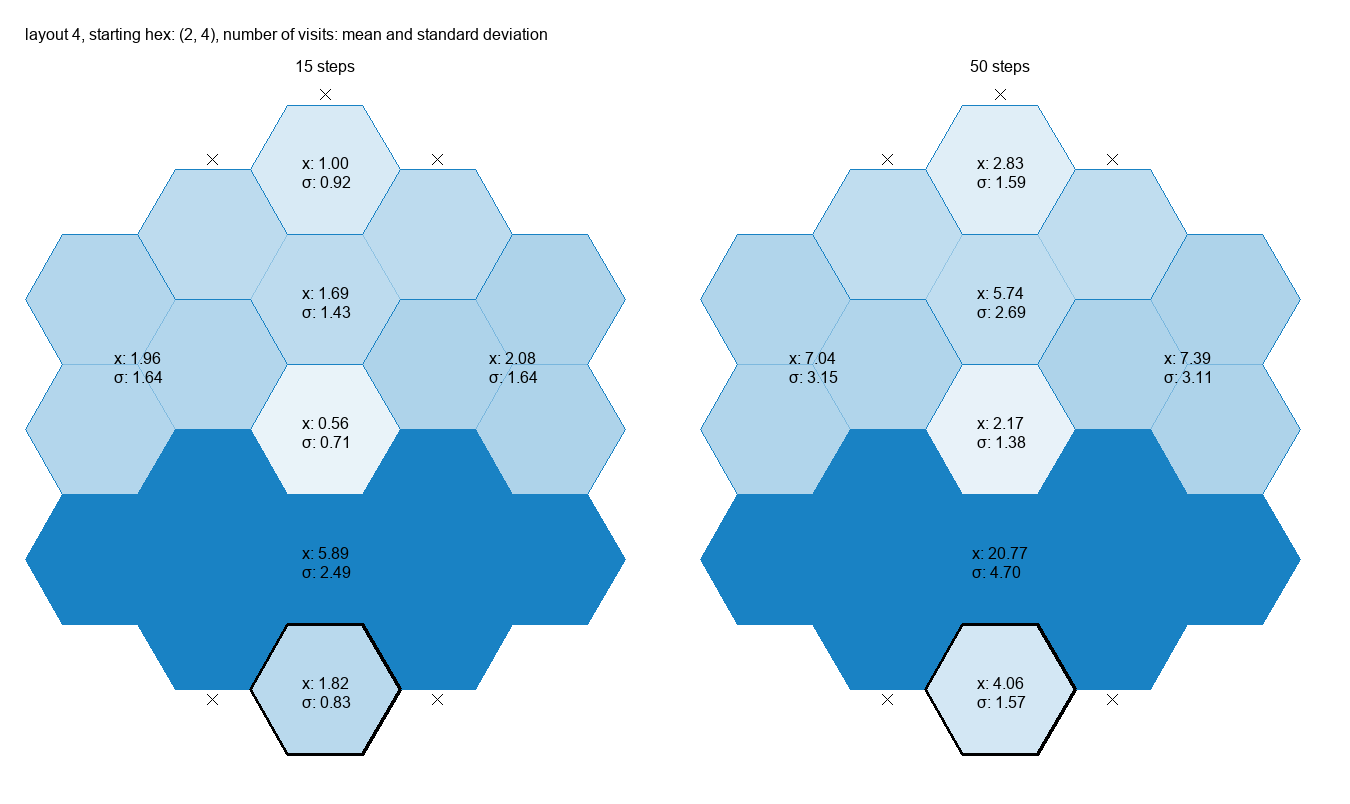

In [10]:
def draw_compare_groups(n_iters = [15, 50], image_type_idx = 1, start_hex=(2, 2)):

    width, height = calc_image_size(2, 1)
    
    # create an image
    image = Image.new("RGBA", (width, height), (255, 255, 255))
    # out.putalpha(1)
   
    # get a drawing context
    d = ImageDraw.Draw(image)
    d.rectangle(((0, 0), image.size), fill=(255, 255, 255))

    flowers = [get_flower(data, x, start_hex) for x in n_iters]
    
    image_flower_offsets = (
        (0, 0),
        (flower_offset, 0)
    )

    for i in range(2):
        draw_collections_flower(
            image,
            d,
            flowers[i],
            image_flower_offsets[i],
            image_type_idx,
            "{} steps".format(n_iters[i])
        )
            
    # draw multiline text
    label = "layout {}, starting hex: ({}, {}), {}".format(btp_idx+1, *start_hex, image_flower_labels[image_type_idx])
    d.text((padding, padding), label, font=fnt, fill=(0, 0, 0))
    
    return image

image = ''

image = draw_compare_groups()

if generate_draw_compare_groups:
    for start_hex in ((2, 2), (2, 4)):
        for i in range(4):
            image = draw_compare_groups(image_type_idx=i, start_hex=start_hex)
            image_type = image_types[i]
            fn = "layout_{}_compare_groups_{}_start_{}_{}.png".format(btp_idx+1, image_type, *start_hex)
            image.save(fn)
            if test_run:
                break
        if test_run:
                break
            
image

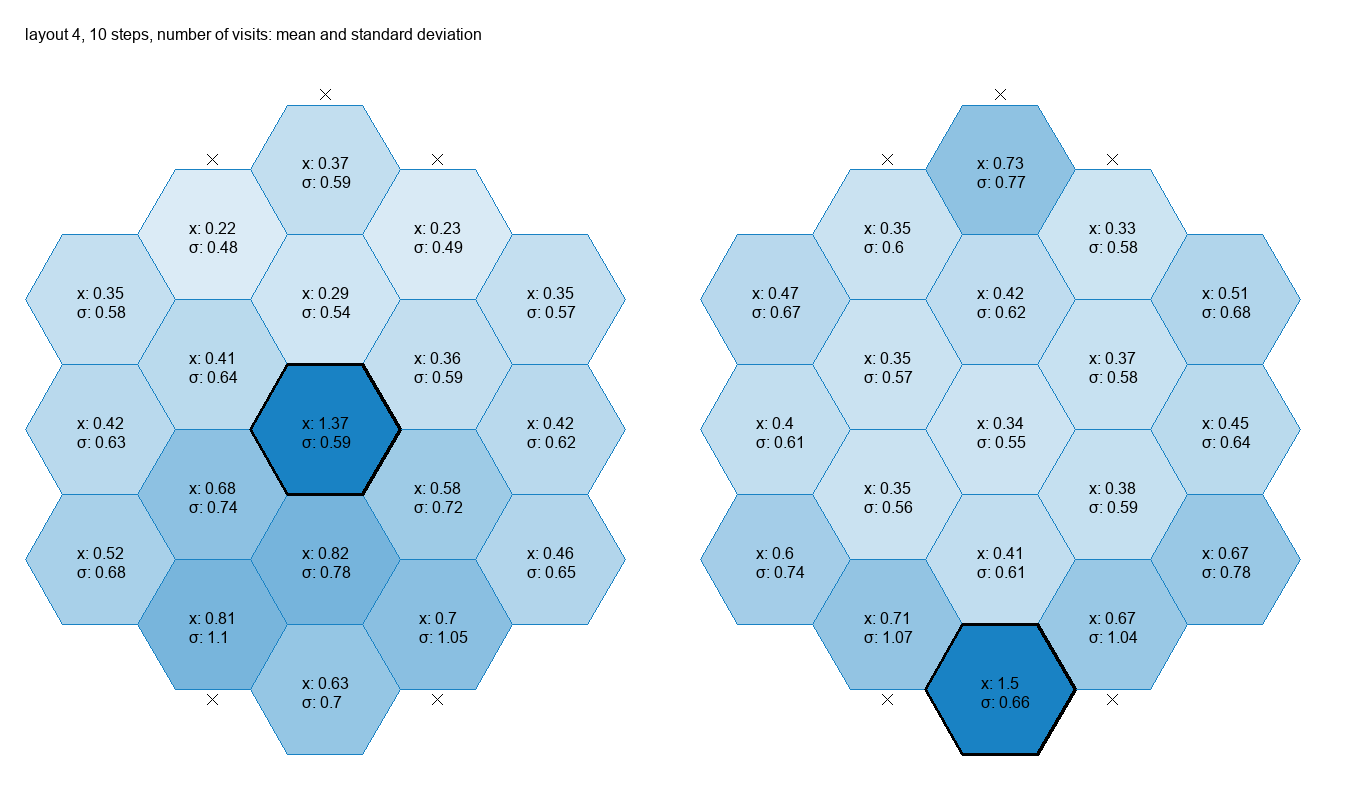

In [11]:
def draw_compare_starts(n_iter = 10, image_type_idx = 0):

    width, height = calc_image_size(2, 1)
    
    # create an image
    image = Image.new("RGBA", (width, height), (255, 255, 255))
    # out.putalpha(1)
   
    # get a drawing context
    d = ImageDraw.Draw(image)
    d.rectangle(((0, 0), image.size), fill=(255, 255, 255))

    start_hexes = [(2, 2), (2, 4)]
    flowers = [get_flower(data, n_iter, x) for x in start_hexes]
    flowers_datas = [get_flower_data(x) for x in flowers]
    
    image_flower_offsets = (
        (0, 0),
        (flower_offset, 0)
    )

    for i in range(2):
        fd = flowers_datas[i]
        draw_flower(
            image,
            d,
            fd['coordinates'],
            fd['labels'][image_types[image_type_idx]],
            base_colors[image_type_idx],
            fd['alphas'][image_types[image_type_idx]],
            image_flower_offsets[i],
            "",
            get_edges(start_hexes[i])
        )
            
    # draw multiline text
    label = "layout {}, {} steps, {}".format(btp_idx+1, n_iter, image_flower_labels[image_type_idx])
    d.text((padding, padding), label, font=fnt, fill=(0, 0, 0))
    
    return image

image = ''

image = draw_compare_starts(image_type_idx=3)

if generate_images:
    for n_iter in n_iters:
        for i in range(4):
            image = draw_compare_starts(n_iter=n_iter, image_type_idx=i)
            image_type = image_types[i]
            fn = "layout_{}_compare_starts_{}_n_steps_{}.png".format(btp_idx+1, image_type, n_iter)
            image.save(fn)
            if test_run:
                break
        if test_run:
            break
    
image

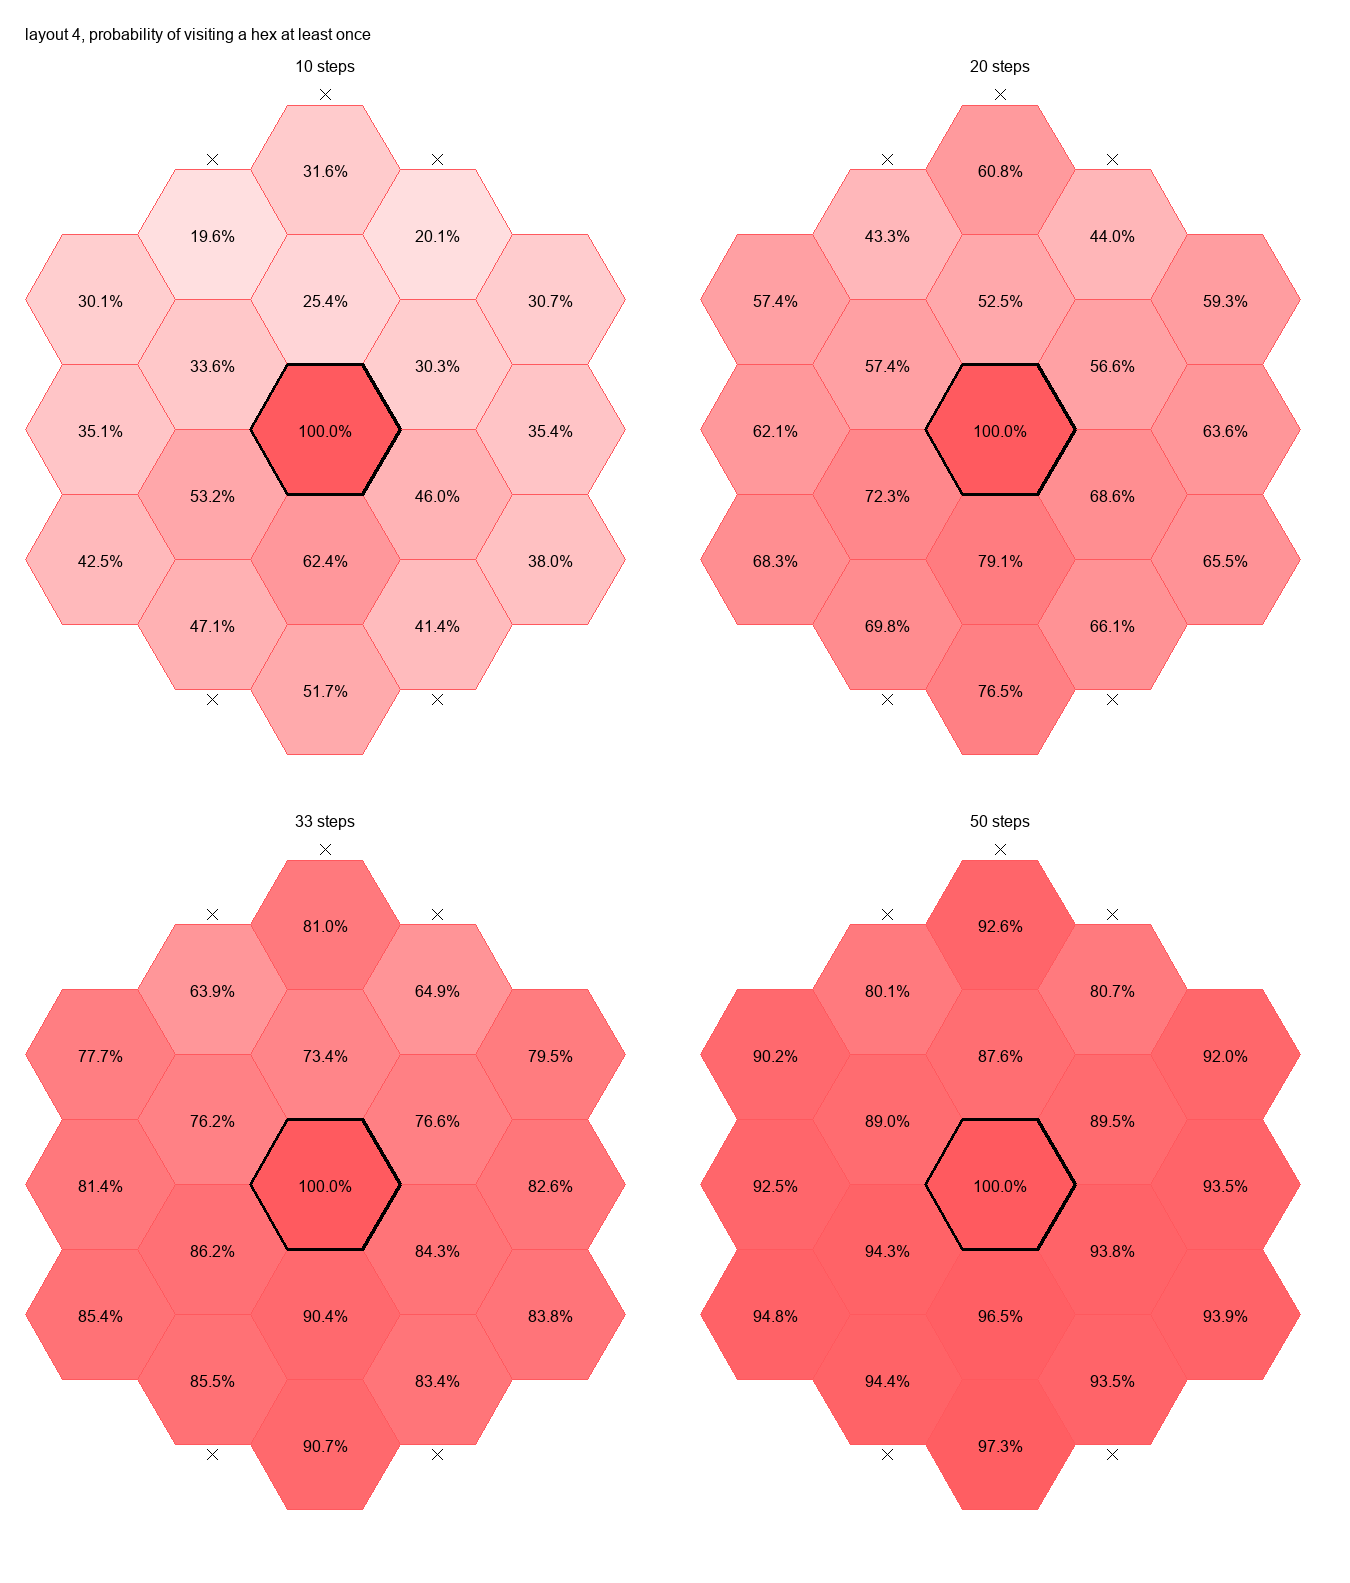

In [12]:
def draw_compare_n_iter(n_iters = [10, 20, 33, 50], image_type_idx = 0, start_hex=(2, 2)):

    width, height = calc_image_size(2, 2)
    
    # create an image
    image = Image.new("RGBA", (width, height), (255, 255, 255))
    # out.putalpha(1)
   
    # get a drawing context
    d = ImageDraw.Draw(image)
    d.rectangle(((0, 0), image.size), fill=(255, 255, 255))
    
    image_flower_offsets = (
        (0, 0),
        (flower_offset, 0),
        (0, flower_offset + y_padding),
        (flower_offset, flower_offset + y_padding)
    )

    for i in range(4):
        flower = get_flower(data, n_iters[i], start_hex)
        fd = get_flower_data(flower)
        draw_flower(
            image,
            d,
            fd['coordinates'],
            fd['labels'][image_types[image_type_idx]],
            base_colors[image_type_idx],
            fd['alphas'][image_types[image_type_idx]],
            image_flower_offsets[i],
            "{} steps".format(n_iters[i]),
            get_edges(start_hex)
        )
            
    # draw multiline text
    label = "layout {}, {}".format(btp_idx+1, image_flower_labels[image_type_idx])
    d.text((padding, padding), label, font=fnt, fill=(0, 0, 0))
    
    return image

image = ''

image = draw_compare_n_iter(image_type_idx=0)

if generate_compare_n_iter_images:
    for i in range(4):
        for start_hex in ((2, 2), (2, 4)):
            image = draw_compare_n_iter(image_type_idx=i, start_hex=start_hex)
            image_type = image_types[i]
            fn = "layout_{}_compare_n_steps_{}_start_{}_{}.png".format(btp_idx+1, image_type, start_hex[0], start_hex[1])
            image.save(fn)
            if test_run:
                break
        if test_run:
            break

image

In [13]:
def draw_compare_layouts(n_iter = 10, image_type_idx = 0, start_hex=(2, 2)):
    width, height = calc_image_size(2, 2)
    
    # create an image
    image = Image.new("RGBA", (width, height), (255, 255, 255))
    # out.putalpha(1)
   
    # get a drawing context
    d = ImageDraw.Draw(image)
    d.rectangle(((0, 0), image.size), fill=(255, 255, 255))
    
    image_flower_offsets = (
        (0, 0),
        (flower_offset, 0),
        (0, flower_offset + y_padding),
        (flower_offset, flower_offset + y_padding)
    )

    for i in range(4):
        set_btp(i)
        image_data = load_data(i)
        flower = get_flower(image_data, n_iter, start_hex)
        # print('flower', flower)
        fd = get_flower_data(flower)
        # print('fd', fd)
        draw_flower(
            image,
            d,
            fd['coordinates'],
            fd['labels'][image_types[image_type_idx]],
            base_colors[image_type_idx],
            fd['alphas'][image_types[image_type_idx]],
            image_flower_offsets[i],
            "layout {}".format(i+1),
            get_edges(start_hex)
        )
            
    # draw multiline text
    label = "compare layouts, {} steps, starting hex: {}, {}".format(n_iter, start_hex, image_flower_labels[image_type_idx])
    d.text((padding, padding), label, font=fnt, fill=(0, 0, 0))
    
    return image

image = ''

if generate_compare_layout_images:
    for n_iter in n_iters:
        for i in range(4):
            for start_hex in ((2, 2), (2, 4)):
                image = draw_compare_layouts(n_iter=n_iter, image_type_idx=i, start_hex=start_hex)
                image_type = image_types[i]
                fn = "compare_layouts_{}_start_{}_{}_n_steps_{}.png".format(image_type, start_hex[0], start_hex[1], n_iter)
                image.save(fn)
                if test_run:
                    break
            if test_run:
                break
        if test_run:
            break
    
image

''